In [88]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

%matplotlib inline

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')

In [3]:
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

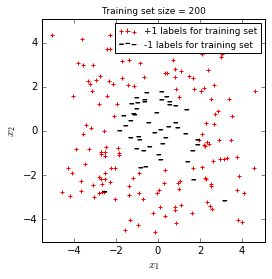

In [4]:
positive_index = np.where(y_train>0)[0]
x_positive = x_train[positive_index]

negative_index = np.where(y_train<=0)[0]
x_negative = x_train[negative_index]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (x_positive[:,0], x_positive[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (x_negative[:,0], x_negative[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [5]:
y_train_label_flat = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train)))
y_train_label = y_train_label_flat.reshape(-1, 1)
# y_test_label = list(map(lambda x: 1 if x > 0 else 0, y_test))

In [6]:
from collections import Counter
from scipy.stats import entropy

# Decision Tree Classifier

In [48]:
#Prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]

In [51]:
def compute_entropy(train_label):
    label_cnt = Counter(train_label.reshape(len(train_label)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    entropy = 0.
    for prob in prob_list:
        if prob == 0.:
            pass
        else:
            entropy += -1. * prob * np.log(prob)
    return entropy

def compute_gini(train_label):
    label_cnt = Counter(train_label.reshape(len(train_label)))
    prob_list = [value/float(sum(label_cnt.values())) for value in label_cnt.values()]
    gini = 0.
    for prob in prob_list:
        gini += prob * (1 - prob)
    return gini

criterion_dict = {'gini': compute_gini, 'entropy': compute_entropy}

In [102]:
class DTree:
    def __init__(self, train_data, train_label, depth=0, criterion='entropy', min_sample=5, max_depth=10):
        self.train = train_data
        self.criterion = criterion
        
        label_cnt = Counter(train_label.reshape(len(train_label)))
        self.label = label_cnt.most_common(1)[0][0]
        
        if len(train_data) < min_sample or depth > max_depth:
            self.is_leaf = True
            return

        self.split_id, self.split_value = self.split_tree(train_data, train_label)

        if self.split_id == -1:
            self.is_leaf = True
            return

        self.is_leaf = False
        left_index = np.where(train_data[:, self.split_id] <= self.split_value)
        right_index = np.where(train_data[:, self.split_id] > self.split_value)
        
        self.left = DTree(train_data[left_index], train_label[left_index], depth+1, criterion=criterion, max_depth=max_depth)
        self.right = DTree(train_data[right_index], train_label[right_index], depth+1, criterion=criterion, max_depth=max_depth)

    def split_tree(self, train_data, train_label):
        split_id = -1
        split_value = np.inf
        min_entropy = criterion_dict[self.criterion](train_label)
        
        for attr_id in range(train_data.shape[1]):
            attr_value = sorted(list(set(train_data[:, attr_id])))
            for i in range(len(attr_value) - 1):
                v = (attr_value[i] + attr_value[i + 1]) / 2.
                left_index_temp = np.where(train_data[:, attr_id] <= v)[0]
                right_index_temp = np.where(train_data[:, attr_id] > v)[0]
                left_entropy = criterion_dict[self.criterion](train_label[left_index_temp])
                right_entropy = criterion_dict[self.criterion](train_label[right_index_temp])
                entropy_ave = (len(left_index_temp) * left_entropy + len(right_index_temp) * right_entropy) / float(len(train_label))
                if entropy_ave < min_entropy:
                    split_id = attr_id
                    split_value = v
                    min_entropy = entropy_ave

        return split_id, split_value

    def predict(self, instance):
        if self.is_leaf:
            return self.label
        if instance[self.split_id] <= self.split_value:
            return self.left.predict(instance)
        else:
            return self.right.predict(instance)

In [64]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree.dot')

In [72]:
!dot -Tpng tree.dot -o tree.png

In [67]:
# Tree_model = DTree(x_train, y_train_label, criterion='gini')
# self_predict_test = [Tree_model.predict(x) for x in x_test]
# clf_predict_test = clf.predict(x_test)

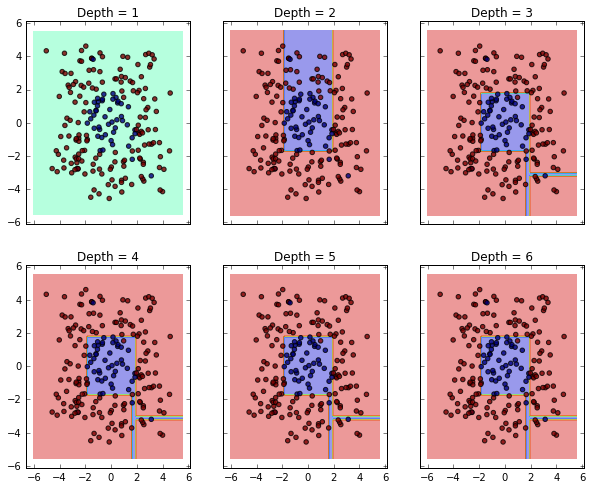

In [103]:
# Loading some example data

# Training classifiers
clf1 = DTree(x_train, y_train_label, criterion='entropy', max_depth=1)
clf2 = DTree(x_train, y_train_label, criterion='entropy', max_depth=2)
clf3 = DTree(x_train, y_train_label, criterion='entropy', max_depth=3)
clf4 = DTree(x_train, y_train_label, criterion='entropy', max_depth=4)
clf5 = DTree(x_train, y_train_label, criterion='entropy', max_depth=5)
clf6 = DTree(x_train, y_train_label, criterion='entropy', max_depth=6)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Decision Tree Regressor

In [118]:
def compute_loss(train_target):
    mean_value = train_target.mean()
    square_loss = sum((train_target - mean_value)**2)[0]
    return square_loss

In [123]:
y_train.mean()

0.52625872787612338

In [130]:
class tree_regressor:
    def __init__(self, train_data, train_target, depth=0, min_sample=5, max_depth=10):
        self.train = train_data
        
        self.value = train_target.mean()
        
        if len(train_data) < min_sample or depth > max_depth:
            self.is_leaf = True
            return

        self.split_id, self.split_value = self.split_tree(train_data, train_target)

        if self.split_id == -1:
            self.is_leaf = True
            return

        self.is_leaf = False
        left_index = np.where(train_data[:, self.split_id] <= self.split_value)
        right_index = np.where(train_data[:, self.split_id] > self.split_value)
        
        self.left = tree_regressor(train_data[left_index], train_target[left_index], depth+1, max_depth=max_depth)
        self.right = tree_regressor(train_data[right_index], train_target[right_index], depth+1, max_depth=max_depth)

    def split_tree(self, train_data, train_target):
        split_id = -1
        split_value = np.inf
        min_loss = compute_loss(train_target)
        
        for attr_id in range(train_data.shape[1]):
            attr_value = sorted(list(set(train_data[:, attr_id])))
            for i in range(len(attr_value) - 1):
                v = (attr_value[i] + attr_value[i + 1]) / 2.
                left_index_temp = np.where(train_data[:, attr_id] <= v)[0]
                right_index_temp = np.where(train_data[:, attr_id] > v)[0]
                left_loss = compute_loss(train_target[left_index_temp])
                right_loss = compute_loss(train_target[right_index_temp])
                total_loss = left_loss + right_loss
                if total_loss < min_loss:
                    split_id = attr_id
                    split_value = v
                    min_loss = total_loss

        return split_id, split_value

    def predict(self, instance):
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict(instance)
        else:
            return self.right.predict(instance)

In [135]:
from sklearn.tree import DecisionTreeRegressor

treg_sk = DecisionTreeRegressor(max_depth=3, min_samples_split=5)
treg_sk.fit(x_train, y_train)
export_graphviz(treg_sk, out_file='tree_regressor.dot')

In [136]:
treg = tree_regressor(x_train, y_train)

In [137]:
!dot -Tpng tree_regressor.dot -o tree_regressor.png

In [141]:
treg.right.left.right.train.shape

(66, 2)